<a href="https://colab.research.google.com/github/mamatqobulovsardor/Outliers/blob/main/Outliers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Chetdagi Qiymatlar (Outliers)

 Ushbu bo‘limda biz mijozlarning hayotiy qiymatini (Customer Lifetime Value) ifodalovchi simulyatsiya qilingan ma’lumotlarimizni tahlil qilib, turli chetdagi qiymatlarni aniqlash va ularni to‘g‘rilash texnikalarini o‘rganamiz. Ushbu bo‘limda quyidagilarni qamrab olamiz:

**Chetdagi Qiymatlarni Aniqlash**  
- Box Plotlar  
- Z-Skorlar  
- Isolation Forests  
- DBSCAN  

**Chetdagi Qiymatlarni Qayta Ishlash**  
- O‘chirish (Removal)  
- Winsorizatsiya  

**Kutubxonalarni Import Qilish**  
Avvalo, tegishli kutubxonalarni import qilishimiz kerak. Ma'lumotlarni boshqarish uchun biz standart **pandas** va **numpy** kutubxonalaridan foydalanamiz. Imputatsiya texnikalarimiz uchun esa **scipy** kutubxonasining ba’zi funksiyalarini ishlatamiz.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

Githubdan linkni olib uqitamz

In [ ]:
!w get https://raw.githubusercontent.com/PlayingNumbers/ML_Process_Course/refs/heads/main/5_data_preprocessing/5_2_outliers/clv_data.csv

 05:35:12 up 6 min,  0 users,  load average: 0.55, 0.80, 0.44
USER     TTY      FROM             LOGIN@   IDLE   JCPU   PCPU WHAT


##**Ma'lumotlarni Yuklash (Load Data)**

Keyingi qadamda biz mijozlarning hayotiy qiymati ma'lumotlar to'plamini yuklaymiz. Ma'lumotlar to'plamimizda taxminan 6 ta ustun mavjud. **Purchases** ustuni mijozlarning hayotiy qiymati muammosida biz uchun muhim hisoblanadi.

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/PlayingNumbers/ML_Process_Course/refs/heads/main/5_data_preprocessing/5_2_outliers/clv_data.csv")

In [ ]:
data

,Unnamed: 0,id,age,gender,income,days_on_platform,city,purchases
0,0,0,NaN,Male,126895,14.0,San Francisco,0
1,1,1,NaN,Male,161474,14.0,Tokyo,0
2,2,2,24.0,Male,104723,34.0,London,1
3,3,3,29.0,Male,43791,28.0,London,2
4,4,4,18.0,Female,132181,26.0,London,2
...,...,...,...,...,...,...,...,...
4995,4995,4995,NaN,Female,212261,28.0,San Francisco,1
4996,4996,4996,NaN,Male,70228,12.0,San Francisco,0
4997,4997,4997,NaN,Male,64995,14.0,New York City,0
4998,4998,4998,NaN,Male,56144,4.0,New York City,2


##Autsayderlarni aniqlash

Avvalo, autsayderlarni aniqlashning turli usullarini ko'rib chiqamiz...

Quti diagrammasi

  Birinchi diagramma sifatida quti diagrammasidan foydalanamiz. Quti diagrammasi ma'lumotlar tarqalishini minimum, maksimum, past chorak, yuqori chorak va medianaga asoslangan holda tasvirlash usulidir. Autsayder esa diagramma "mo‘ylovlari" tashqarisiga tushgan ma'lumot nuqtasi hisoblanadi. Ushbu diagrammada ko'rib turganingizdek, mo‘ylovdan yuqoridagi ma'lumot nuqtasi autsayder sifatida qaraladi:

<Axes: ylabel='purchases'>

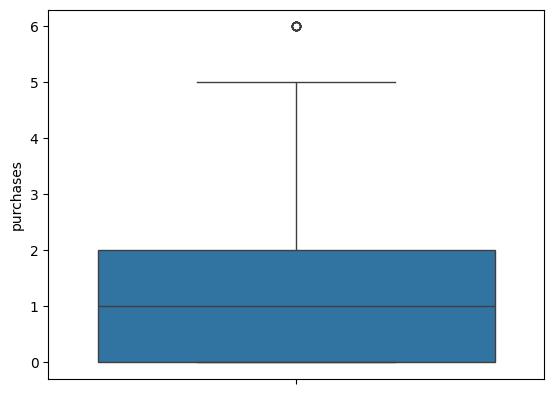

In [ ]:
sns.boxplot(data['purchases'])

In [ ]:
import numpy as np

def extract_outliers_from_boxplot(array):
    # Get IQR
    iqr_q1 = np.quantile(array, 0.25)
    iqr_q3 = np.quantile(array, 0.75)
    med = np.median(array)

    # Finding the IQR region
    iqr = iqr_q3 - iqr_q1

    # Finding upper and lower whiskers
    upper_bound = iqr_q3 + (1.5 * iqr)
    lower_bound = iqr_q1 - (1.5 * iqr)

    outliers = array[(array <= lower_bound) | (array >= upper_bound)]
    print('Outliers within the box plot are :{}'.format(outliers))
    return outliers

# Example usage
extract_outliers_from_boxplot(data['purchases'])


Outliers within the box plot are :47      5
142     5
301     5
323     5
485     6
1104    6
1112    5
1623    5
1670    5
1818    5
2180    5
2463    6
2548    5
2605    5
2717    5
2901    5
3032    6
3291    5
3321    5
3361    5
3380    5
3410    5
3631    6
3835    5
3848    5
4003    6
4334    5
4346    5
4611    5
4662    5
4895    5
4958    5
Name: purchases, dtype: int64


,purchases
47,5
142,5
301,5
323,5
485,6
1104,6
1112,5
1623,5
1670,5
1818,5


##Skripka diagrammasi

  Quti diagrammasiga muqobil sifatida skripka diagrammasidan foydalanish mumkin. Skripka diagrammasi quti diagrammasidagi barcha ma'lumotlarni o'z ichiga oladi va ularga zichlik shakllarini ham qo'shadi. Bu sizga nuqtalaringiz butun ma'lumotlar to'plami bo'ylab qanday tarqalganini ko'rish imkonini beradi:

{'bodies': [<matplotlib.collections.PolyCollection at 0x7e6e35f2c5b0>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7e6e355d0a00>,
 'cmins': <matplotlib.collections.LineCollection at 0x7e6e355da410>,
 'cbars': <matplotlib.collections.LineCollection at 0x7e6e355da470>}

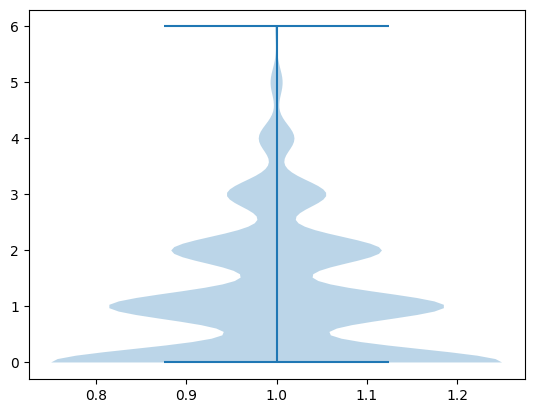

In [ ]:
plt.violinplot(data['purchases'])

##Z-ballar

 Quti diagrammalariga o'xshash usul sifatida z-ballardan foydalanish mumkin. Asosiy farq shundaki, z-ballardan foydalanishda biz biror nuqtani autsayder sifatida tasniflash uchun ishlatmoqchi bo'lgan foizni aniq belgilashimiz mumkin:

In [ ]:
purchases = data['purchases']

def percentile_outliers(array,
                        lower_bound_perc,
                        upper_bound_perc):

    upper_bound = np.percentile(data['purchases'], upper_bound_perc)
    lower_bound = np.percentile(data['purchases'], lower_bound_perc)

    outliers = array[(array <= lower_bound) | (array >= upper_bound)]

    return outliers

def z_score_outliers(array,
                     z_score_lower,
                     z_score_upper):

    z_scores = scipy.stats.zscore(array)
    outliers = (z_scores > 1.96) | (z_scores < -1.96)

    return array[outliers]

In [ ]:
outliers = percentile_outliers(data['purchases'],
               upper_bound_perc = 99,
               lower_bound_perc = 1)

In [ ]:
z_score_outliers(data['purchases'],
                     z_score_lower = -1.96,
                     z_score_upper = 1.96)

,purchases
47,5
51,4
74,4
117,4
142,5
...,...
4843,4
4880,4
4895,5
4897,4


##Izolyatsiya o'rmonlari

 Keyingi usul — algoritmik yondashuv bo'lib, u Izolyatsiya o'rmonlari deb ataladi. Izolyatsiya o'rmoni asosan qaror daraxti bo'lib, tasodifiy ravishda biror xususiyatni tanlab, uni bo'linadi. Autsayderlar, ehtimol, birinchi bo'lib qaror daraxti tomonidan bo'linadi, bu bizga autsayderlarning qaerda joylashganini ko'rsatadi:

In [ ]:
from sklearn.ensemble import IsolationForest

features = ['age','income','days_on_platform','purchases']

## We'll do a simple drop null for now
df = df.dropna()

## Create a training-test set
X = df[features]
X_train = X[:4000]
X_test = X[1000:]

## Fit Model
clf = IsolationForest(n_estimators=50, max_samples=100)
clf.fit(X_train)

## Get Scores
df['scores'] = clf.decision_function(X_train)
df['anomaly'] = clf.predict(X)

## Get Anomalies
outliers=df.loc[df['anomaly']==-1]

outliers

,Unnamed: 0,id,age,gender,income,days_on_platform,city,purchases,scores,anomaly
15,15,15,31.0,Female,226249,20.0,Miami,0,-0.030325,-1
17,17,17,27.0,Female,177582,2.0,London,0,-0.021859,-1
18,18,18,10.0,Female,260,32.0,San Francisco,0,-0.026520,-1
23,23,23,10.0,Female,108804,5.0,Tokyo,2,-0.022292,-1
25,25,25,46.0,Female,112992,9.0,London,3,-0.033194,-1
...,...,...,...,...,...,...,...,...,...,...
4969,4969,4969,49.0,Female,28243,13.0,New York City,0,-0.005500,-1
4970,4970,4970,34.0,Female,9850,3.0,New York City,3,-0.037305,-1
4979,4979,4979,50.0,Male,90750,71.0,New York City,1,-0.068992,-1
4984,4984,4984,24.0,Female,225155,8.0,San Francisco,2,-0.063957,-1


##Autsayderlarni davolash  

Endi bizda autsayderlarni aniqlash usullari bor, keling, autsayderlarni davolashning turli usullarini ko'rib chiqaylik.

##O'chirish

 Birinchi usul — faqatgina autsayderlarni o'chirish. Autsayderlarni o'chirishning odatiy usuli z-balli o'chirishdir. Siz autsayderlaringiz uchun z-bali yoki foiz kesishini belgilaysiz, so'ngra shu chegaradan yuqori yoki past bo'lgan har qanday nuqtani o'chirasiz. Biz siz foydalanishingiz mumkin bo'lgan bir nechta funksiyalarni yozib chiqdik:

In [ ]:
def z_score_removal(df, column, lower_z_score, upper_z_score):

    col_df = df[column]

    z_scores = scipy.stats.zscore(purchases)
    outliers = (z_scores > upper_z_score) | (z_scores < lower_z_score)
    return df[~outliers]

def percentile_removal(df, column, lower_bound_perc, upper_bound_perc):

    col_df = df[column]

    upper_bound = np.percentile(col_df, upper_bound_perc)
    lower_bound = np.percentile(col_df, lower_bound_perc)

    z_scores = scipy.stats.zscore(purchases)
    outliers = (z_scores > upper_bound) | (z_scores < lower_bound)
    return df[~outliers]

filtered_df = z_score_removal(df, 'purchases', -1.96, 1.96)
percentile_removal(df, 'purchases', lower_bound_perc = 1, upper_bound_perc = 99)

,Unnamed: 0,id,age,gender,income,days_on_platform,city,purchases,scores,anomaly
3,3,3,29.0,Male,43791,28.0,London,2,0.065221,1
4,4,4,18.0,Female,132181,26.0,London,2,0.034893,1
9,9,9,49.0,Female,76842,19.0,Tokyo,2,0.002780,1
23,23,23,10.0,Female,108804,5.0,Tokyo,2,-0.022292,-1
25,25,25,46.0,Female,112992,9.0,London,3,-0.033194,-1
...,...,...,...,...,...,...,...,...,...,...
4953,4953,4953,33.0,Male,90302,21.0,Tokyo,3,0.005630,1
4958,4958,4958,47.0,Female,79452,4.0,New York City,5,-0.143079,-1
4970,4970,4970,34.0,Female,9850,3.0,New York City,3,-0.037305,-1
4984,4984,4984,24.0,Female,225155,8.0,San Francisco,2,-0.063957,-1


##Winsorizatsiya  

Autsayderlarni o'chirish eng oddiy yondashuvdir. Agar siz ushbu satrlar qiymatli deb hisoblaysiz, biz autsayderlarni winsorizatsiya qilishimiz mumkin, ya'ni autsayderlarni "cheklash". Agar autsayder qiymati ma'lum bir chegaradan yuqori bo'lsa, uni o'sha chegara qiymati bilan almashtiramiz. Bu yerda biz siz uchun bir funktsiya yozib chiqdik:

In [ ]:
def winsorize(df, column, upper, lower):
    col_df = df[column]

    perc_upper = np.percentile(df[column],upper)
    perc_lower = np.percentile(df[column],lower)

    df[column] = np.where(df[column] >= perc_upper,
                          perc_upper,
                          df[column])

    df[column] = np.where(df[column] <= perc_lower,
                          perc_lower,
                          df[column])

    return df

In [ ]:
winsorize(df, 'purchases', 97.5, 0.025)

,Unnamed: 0,id,age,gender,income,days_on_platform,city,purchases,scores,anomaly
2,2,2,24.0,Male,104723,34.0,London,1.0,0.059901,1
3,3,3,29.0,Male,43791,28.0,London,2.0,0.065221,1
4,4,4,18.0,Female,132181,26.0,London,2.0,0.034893,1
5,5,5,23.0,Male,12315,14.0,New York City,0.0,0.030297,1
8,8,8,46.0,Male,129157,23.0,New York City,0.0,0.024468,1
...,...,...,...,...,...,...,...,...,...,...
4986,4986,4986,23.0,Male,75425,6.0,London,1.0,0.060697,1
4989,4989,4989,47.0,Female,84987,30.0,Tokyo,0.0,0.032821,1
4990,4990,4990,33.0,Male,3020,89.0,New York City,0.0,-0.108053,-1
4991,4991,4991,36.0,Female,26173,34.0,Tokyo,0.0,0.062333,1
